# Notebook for Model Experimentation:
1. Going to begin by trying simple clustering techniques to see if the data clusters conveniently, will probably fail

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# shows all columns and all rows if you print the df
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", None)

In [2]:
df = pd.read_csv("../data/data_unzipped/netflix_titles.csv")
df.head()

show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   
3                                                NaN            NaN   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min   
1  September 24, 2021          2021  TV-MA  2 Seasons   
2  September 24, 2021          2021  TV-MA   1 Season   
3  September 24, 2021          2021  TV-MA   1 Season   
4  September 24, 2021          2021  TV-MA  2 Seasons   

                                           listed_in  \
0                                      Documentaries   
1    International TV Shows, TV Dramas, TV Mysteries   
2  Crime TV Shows, International TV Shows, TV Act...   
3                             Docuseries, Reality TV   
4  International TV Shows, Romantic TV Shows, TV ...   

                                         description  
0  As her father nears the end of his life, filmm...  
1  After crossing paths at a party, a Cape Town t...  
2  To protect his family from a powerful drug lor...  
3  Feuds, flirtations and toilet talk go down amo...  
4  In a city of coaching centers known to train I...

# Preprocess Data and Replace Missing Values

In [3]:
df.isna().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

In [4]:
#convert date column:
df['date'] = df['date_added'].str.strip()
df['date'] = pd.to_datetime(df['date'])

df_date = df.sort_values(by='date', ascending=False).reset_index(drop=True)
df.dropna(subset='date', inplace=True)

df.drop(columns='date_added', inplace=True)

In [5]:
cols_to_manually_fill = ['director', 'cast']

#filling director and cast with N/A, dont really have an imputing strategy here:
df[cols_to_manually_fill] = df[cols_to_manually_fill].fillna("N/A")

In [6]:
from sklearn.impute import SimpleImputer

cols_to_impute = ['country', 'rating', 'duration']
imputer = SimpleImputer(strategy="most_frequent")
df[cols_to_impute] = imputer.fit_transform(df[cols_to_impute])

In [7]:
df.isna().sum()

show_id         0
type            0
title           0
director        0
cast            0
country         0
release_year    0
rating          0
duration        0
listed_in       0
description     0
date            0
dtype: int64

In [8]:
df.head()

show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              N/A   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              N/A   
4      s5  TV Show           Kota Factory              N/A   

                                                cast        country  \
0                                                N/A  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...  United States   
3                                                N/A  United States   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

   release_year rating   duration  \
0          2020  PG-13     90 min   
1          2021  TV-MA  2 Seasons   
2          2021  TV-MA   1 Season   
3          2021  TV-MA   1 Season   
4          2021  TV-MA  2 Seasons   

                                           listed_in  \
0                                      Documentaries   
1    International TV Shows, TV Dramas, TV Mysteries   
2  Crime TV Shows, International TV Shows, TV Act...   
3                             Docuseries, Reality TV   
4  International TV Shows, Romantic TV Shows, TV ...   

                                         description       date  
0  As her father nears the end of his life, filmm... 2021-09-25  
1  After crossing paths at a party, a Cape Town t... 2021-09-24  
2  To protect his family from a powerful drug lor... 2021-09-24  
3  Feuds, flirtations and toilet talk go down amo... 2021-09-24  
4  In a city of coaching centers known to train I... 2021-09-24

# Now to engineer some features from what we have

In [9]:
# easy ones:

#for idempotency, makes every cell infinitely re-runnable
df_engineered = df.copy()

#description kinda useless tbh
df_engineered = df_engineered.drop(columns="description")

#rename for ease of use
df_engineered = df_engineered.rename(columns={"listed_in":"genre"})

# grab the year on its own
df_engineered['year_added'] = df_engineered['date'].dt.year

In [17]:
"""
Here I am just exploding out the columns that have tons of comma separated values
"""
def explode_column(df, column):
    df_exploded = df[column].str.strip().str.split(",", expand=True)
    num_columns = df_exploded.shape[1]
    column_names = [f"{column}-{i}" for i in range(0, num_columns)]
    df_exploded.columns = column_names
    return df_exploded

#drop original country column:

df_director_exploded = explode_column(df_engineered, "director")
df_countries_exploded = explode_column(df_engineered, "country")
df_cast_exploded = explode_column(df_engineered, "cast")
df_genre_exploded = explode_column(df_engineered, "genre")

In [18]:
"""
Bring them all together, its a little cumbersome but it works:
"""
df_concat = pd.concat([df_engineered, df_director_exploded, df_countries_exploded, df_cast_exploded, df_genre_exploded], axis=1)
df_concat = df_concat.fillna("N/A")
df_concat = df_concat.drop(columns=['country', 'director', 'cast', 'genre'])
df_concat.head(2)

show_id     type                 title  release_year rating   duration  \
0      s1    Movie  Dick Johnson Is Dead          2020  PG-13     90 min   
1      s2  TV Show         Blood & Water          2021  TV-MA  2 Seasons   

        date  year_added       director-0 director-1 director-2 director-3  \
0 2021-09-25        2021  Kirsten Johnson        N/A        N/A        N/A   
1 2021-09-24        2021              N/A        N/A        N/A        N/A   

  director-4 director-5 director-6 director-7 director-8 director-9  \
0        N/A        N/A        N/A        N/A        N/A        N/A   
1        N/A        N/A        N/A        N/A        N/A        N/A   

  director-10 director-11 director-12      country-0 country-1 country-2  \
0         N/A         N/A         N/A  United States       N/A       N/A   
1         N/A         N/A         N/A   South Africa       N/A       N/A   

  country-3 country-4 country-5 country-6 country-7 country-8 country-9  \
0       N/A       N/A       N/A       N/A       N/A       N/A       N/A   
1       N/A       N/A       N/A       N/A       N/A       N/A       N/A   

  country-10 country-11      cast-0        cast-1          cast-2  \
0        N/A        N/A         N/A           N/A             N/A   
1        N/A        N/A  Ama Qamata   Khosi Ngema   Gail Mabalane   

            cast-3             cast-4            cast-5        cast-6  \
0              N/A                N/A               N/A           N/A   
1   Thabang Molaba   Dillon Windvogel   Natasha Thahane   Arno Greeff   

               cast-7            cast-8           cast-9         cast-10  \
0                 N/A               N/A              N/A             N/A   
1   Xolile Tshabalala   Getmore Sithole   Cindy Mahlangu   Ryle De Morny   

            cast-11                cast-12       cast-13          cast-14  \
0               N/A                    N/A           N/A              N/A   
1   Greteli Fincham   Sello Maake Ka-Ncube   Odwa Gwanya   Mekaila Mathys   

          cast-15          cast-16           cast-17            cast-18  \
0             N/A              N/A               N/A                N/A   
1   Sandi Schultz   Duane Williams   Shamilla Miller   Patrick Mofokeng   

  cast-19 cast-20 cast-21 cast-22 cast-23 cast-24 cast-25 cast-26 cast-27  \
0     N/A     N/A     N/A     N/A     N/A     N/A     N/A     N/A     N/A   
1     N/A     N/A     N/A     N/A     N/A     N/A     N/A     N/A     N/A   

  cast-28 cast-29 cast-30 cast-31 cast-32 cast-33 cast-34 cast-35 cast-36  \
0     N/A     N/A     N/A     N/A     N/A     N/A     N/A     N/A     N/A   
1     N/A     N/A     N/A     N/A     N/A     N/A     N/A     N/A     N/A   

  cast-37 cast-38 cast-39 cast-40 cast-41 cast-42 cast-43 cast-44 cast-45  \
0     N/A     N/A     N/A     N/A     N/A     N/A     N/A     N/A     N/A   
1     N/A     N/A     N/A     N/A     N/A     N/A     N/A     N/A     N/A   

  cast-46 cast-47 cast-48 cast-49                 genre-0     genre-1  \
0     N/A     N/A     N/A     N/A           Documentaries         N/A   
1     N/A     N/A     N/A     N/A  International TV Shows   TV Dramas   

         genre-2  
0            N/A  
1   TV Mysteries

# Analyze `type`, Movies vs. TV Show

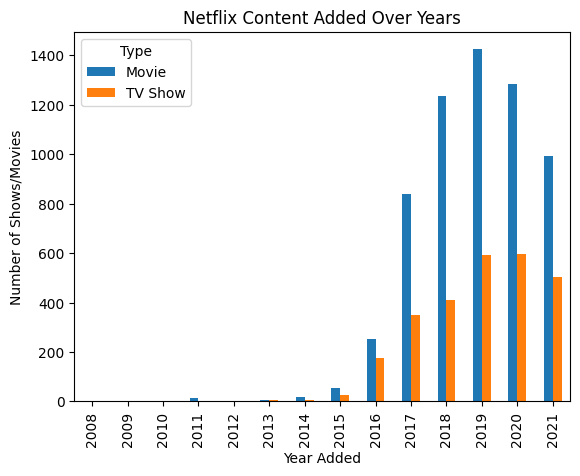

In [19]:
year_type_counts = df_concat.groupby(['year_added', 'type']).size().unstack(fill_value=0)

#significantly more movies than tv shows added to netflix over time
year_type_counts.plot(kind='bar', stacked=False)
plt.title('Netflix Content Added Over Years')
plt.xlabel('Year Added')
plt.ylabel('Number of Shows/Movies')
plt.legend(title='Type')
plt.show()

In [20]:
"""
Aggregates counts for an exploded column in the dataframe by year.

Parameters:
df (DataFrame): The source dataframe.
column (str): The base name of the exploded column.

Returns:
DataFrame: Yearly counts of the shows/movies for each category in the exploded column.
DataFrame: Total counts for each category in the exploded column across all years.
"""
def counts_per_exploded_column(df, column):
    valid_cols = [col for col in df.columns if col.startswith(f"{column}-")]
    df_melted = df.melt(id_vars=['show_id', 'year_added', 'type'], value_vars=valid_cols, var_name=f'{column}-var', value_name=f"{column}")
    df_melted[column] = df_melted[column].str.strip()
    
    #remove duplicates and get the show/movie counts by country
    df_melted.drop_duplicates(subset=['show_id', f"{column}"], inplace=True)
    column_year_counts = df_melted.groupby(['year_added', f"{column}"]).size().unstack(fill_value=0)
    total_counts_per_column = column_year_counts.sum(axis=0)

    return column_year_counts, total_counts_per_column

In [38]:
"""
This function essentially plots the output of the above function, they are very much linked, only separated for analysis purposes:
"""
def generate_barplot_exploded_column(column_year_counts, total_counts_per_column, column_name, threshold):
    
    filtered_column = total_counts_per_column[total_counts_per_column > threshold].index.tolist()
    
    filtered_column = [column for column in filtered_column if column!="N/A"]
    
    #filter by these countries with >=50 shows/movies per year
    filtered_column_year_counts = column_year_counts[filtered_column]
    
    filtered_column_year_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
    plt.title(f'Number of Netflix Shows/Movies Added Per {column_name} Over Years Where There Were >= {threshold} Additions Per Director')
    plt.xlabel('Year Added')
    plt.ylabel('Number of Shows/Movies')
    plt.show()

# Analyze `Director`:

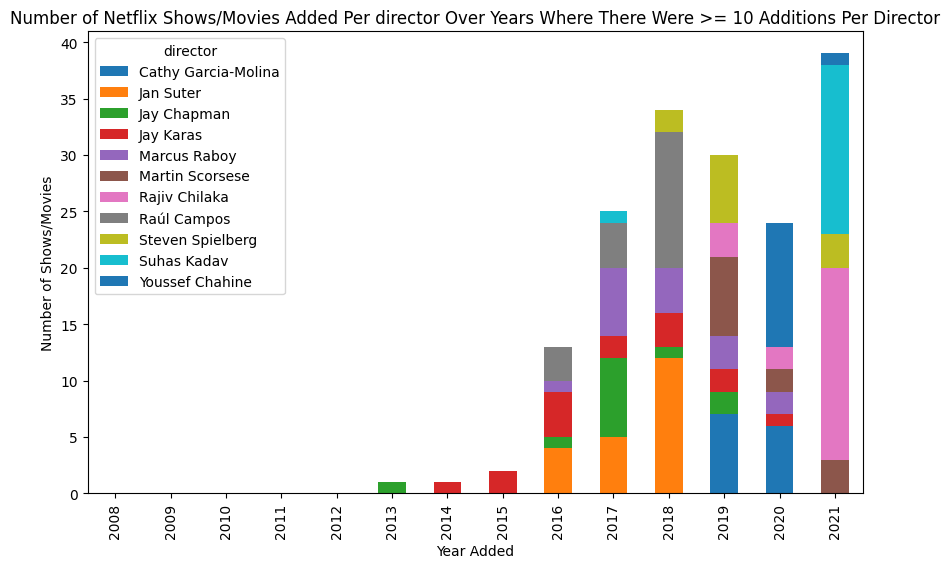

In [34]:
"""
The next few cells will just use the util functions defined above
"""
director_year_counts, total_counts_per_director = counts_per_exploded_column(df_concat, "director")

threshold = 10

generate_barplot_exploded_column(director_year_counts, total_counts_per_director, "director", threshold)

# Analyze `Country`:

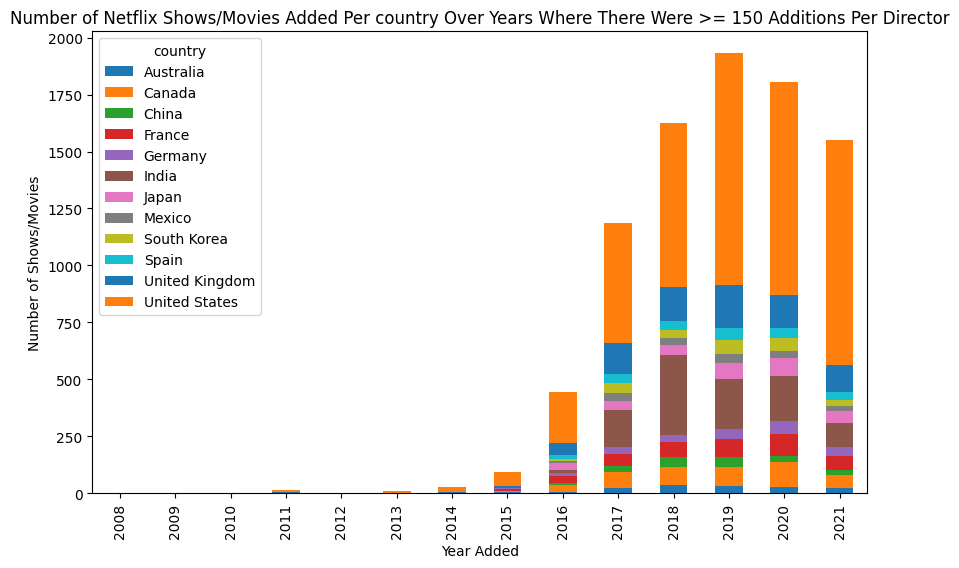

In [35]:
#filter by countries that actually place so this figure works lol
country_year_counts, total_counts_per_country = counts_per_exploded_column(df_concat, "country")

threshold = 150

generate_barplot_exploded_column(country_year_counts, total_counts_per_country, "country", threshold)

# Analyze `Genre`: 

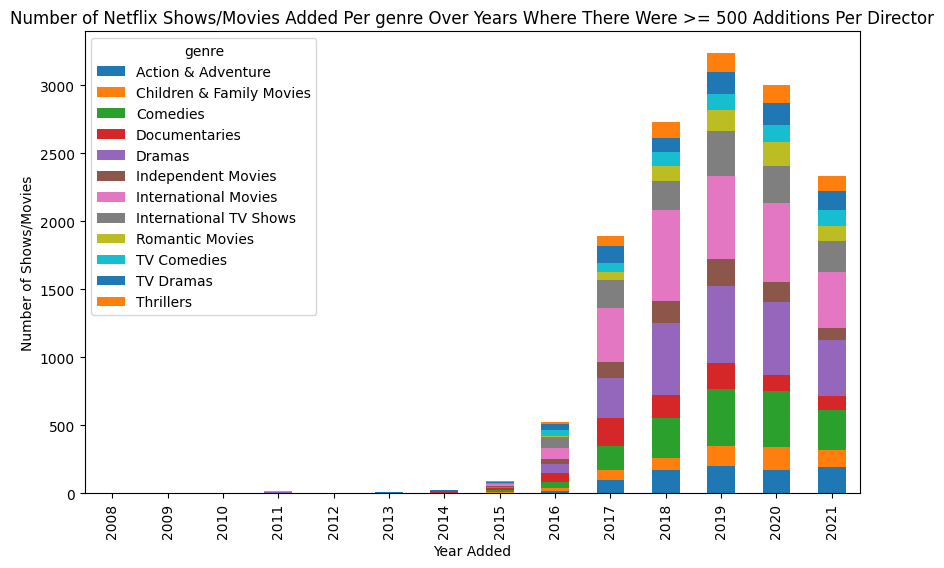

In [36]:
genre_year_counts, total_counts_per_genre = counts_per_exploded_column(df_concat, "genre")

threshold = 500

generate_barplot_exploded_column(genre_year_counts, total_counts_per_genre, "genre", threshold)

# Analyze `Cast`:

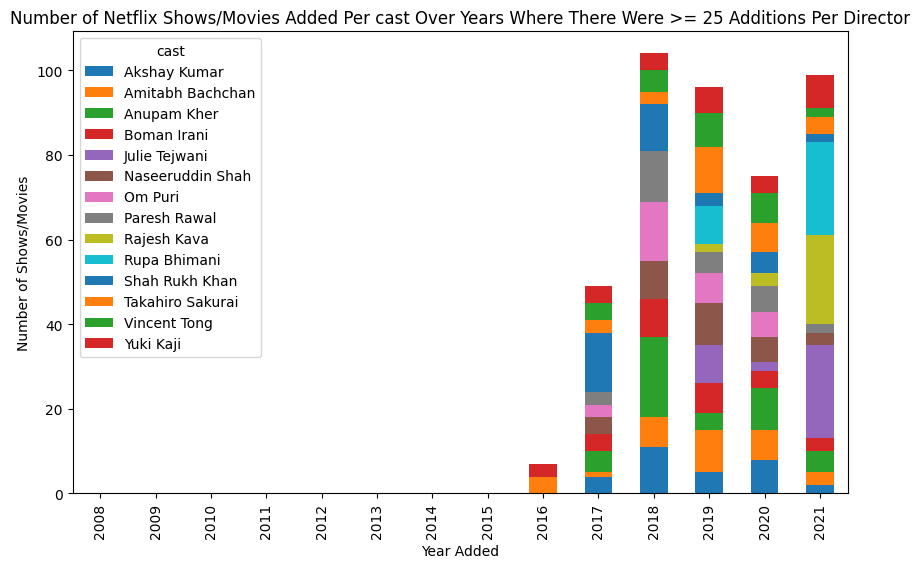

In [37]:
"""
So the most common actors are absolutely from India no doubt:
"""
cast_year_counts, total_counts_per_castmember = counts_per_exploded_column(df_concat, "cast")

threshold = 25

generate_barplot_exploded_column(cast_year_counts, total_counts_per_castmember, "cast", threshold)

# Going to Calculate `Director`, `Country`, and `Genre` with Highest Positive Rate of Change:
- Note: `Cast` was too big, literally took forever then broke, idk but it would have just been a bollywood actor anyways
- Note: Sorry the plots at the bottom look like ass lmao.

In [90]:

"""
Loops over all columns 5 times to get the columns with the highest positive rate of change

An example, USA released the most movies out of any country so it had the highest rate of change of movie releases from 2008 -> 2021

"""
def calculate_max_roc_column(df):
    top5_roc = []
    top5_column = []

    #cleaning so that we produce valid results
    df_dropped = df.drop(columns=["N/A", "year_added"])
    df_dropped.columns = df_dropped.columns.str.replace('"', '').str.replace("'", '')

    while(len(top5_roc) < 5):

        max_roc = 0
        max_column = ""
        
        for column in df_dropped.columns:
            column_roc = df_dropped[f"{column}"].diff().sum()
            if column_roc > max_roc:
                max_roc = column_roc
                max_column = column

        top5_roc.append(max_roc)
        top5_column.append(max_column)

        df_dropped.drop(columns=max_column, inplace=True)

    return top5_column, top5_roc

In [91]:
# need year_added to be a column, not the index:
director_year_counts_roc = director_year_counts.reset_index()
country_year_counts_roc = country_year_counts.reset_index()
genre_year_counts_roc = genre_year_counts.reset_index()

In [92]:
top5_directors, top5_director_rocs = calculate_max_roc_column(director_year_counts_roc)

for director, rate_of_change in zip(top5_directors, top5_director_rocs):
    print(f"Director: {director}, RoC: {rate_of_change}")

Director: Rajiv Chilaka, RoC: 17.0
Director: Suhas Kadav, RoC: 15.0
Director: Hidenori Inoue, RoC: 7.0
Director: Lasse Hallstr√∂m, RoC: 5.0
Director: Rathindran R Prasad, RoC: 5.0


In [93]:
top5_countries, top5_country_rocs = calculate_max_roc_column(country_year_counts_roc)

for country, rate_of_change in zip(top5_countries, top5_country_rocs):
    print(f"Country: {country}, RoC: {rate_of_change}")

Country: United States, RoC: 983.0
Country: United Kingdom, RoC: 120.0
Country: India, RoC: 105.0
Country: France, RoC: 60.0
Country: Canada, RoC: 59.0


In [94]:
top5_genres, top5_genres_rocs = calculate_max_roc_column(genre_year_counts_roc)

for genre, rate_of_change in zip(top5_genres, top5_genres_rocs):
    print(f"Genre: {genre}, RoC: {rate_of_change}")

Genre: Dramas, RoC: 411.0
Genre: International Movies, RoC: 408.0
Genre: Comedies, RoC: 299.0
Genre: International TV Shows, RoC: 229.0
Genre: Action & Adventure, RoC: 196.0


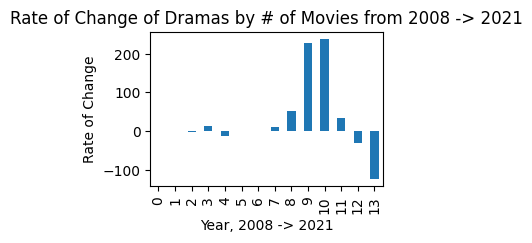

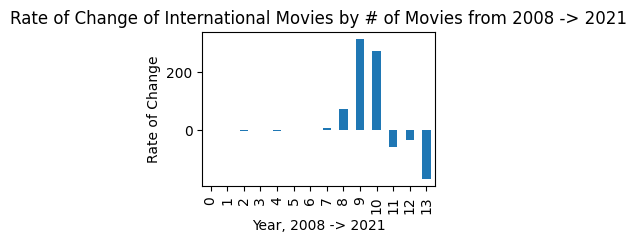

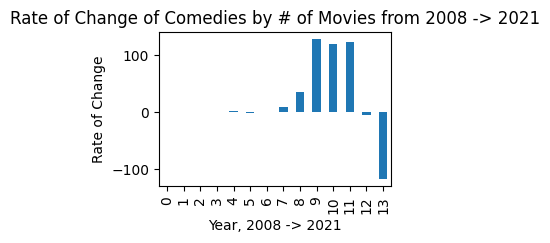

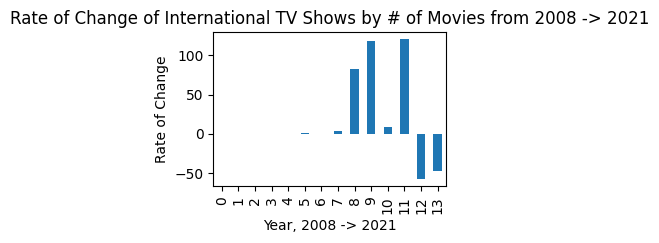

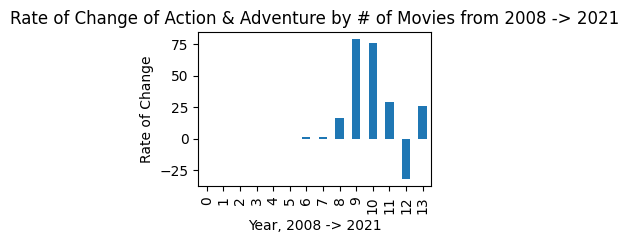

In [109]:
# I would look pre 2019, as covid definitely caused the big consistent dip
for col in top5_genres: 
    genre_year_counts_roc[col].diff().plot(kind="bar", figsize=(3,2))
    plt.xlabel("Year, 2008 -> 2021")
    plt.ylabel("Rate of Change")
    plt.title(f"Rate of Change of {col} by # of Movies from 2008 -> 2021")
    plt.show()

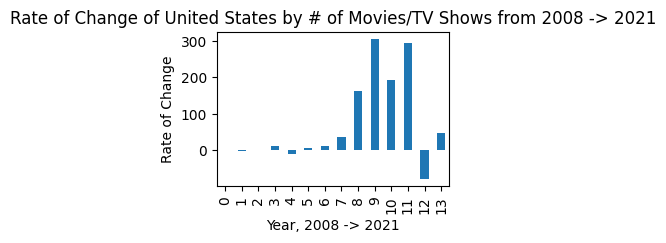

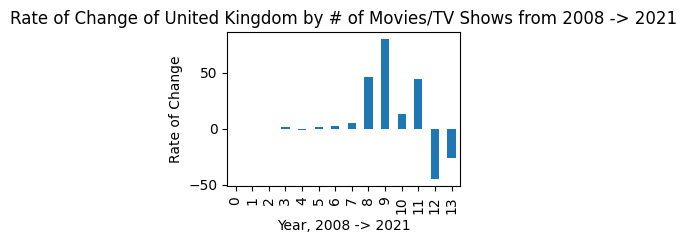

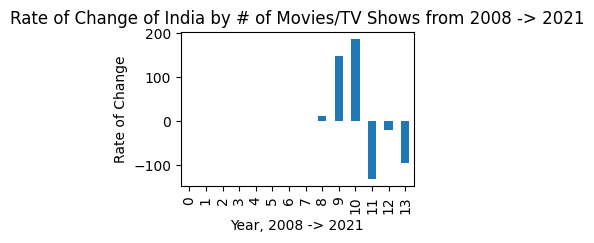

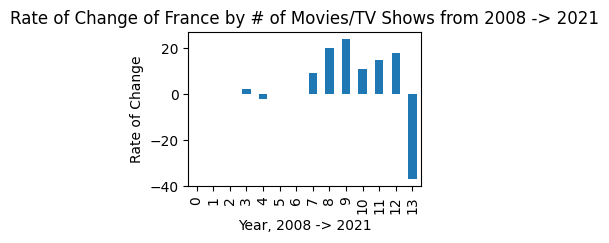

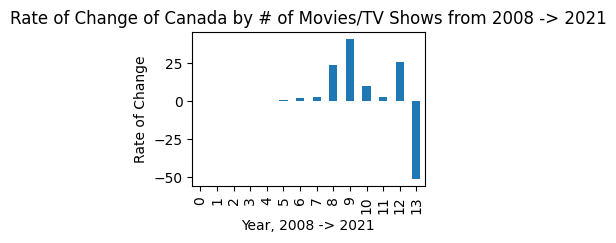

In [107]:
# I would look pre 2019, as covid definitely caused the big consistent dip
for col in top5_countries: 
     country_year_counts_roc[col].diff().plot(kind="bar", figsize=(3,2))
     plt.xlabel("Year, 2008 -> 2021")
     plt.ylabel("Rate of Change")
     plt.title(f"Rate of Change of {col} by # of Movies/TV Shows from 2008 -> 2021")
     plt.show()